# 0. Setup

In [7]:

import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import models
import tensorflow as tf
import os
from keras.models import load_model

In [33]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, weight1, weight2, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = weight1
        self.w2 = weight2

    def get_config(self):
        config = super().get_config()
        config.update({
            "weightq": self.w1,
            "weight2": self.w2,
        })
        return config

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1]

# 1. Hyperparameters

In [20]:
input_height = 69
input_width = 69
input_depth = 3
batch_size = 64

In [21]:
paths = {
    'CNN_DIR' : os.path.join('data','workspace','models', 'CNN_dropout_batch_bigger_class_weights.h5'),
    'VGG_DIR' : os.path.join('data','workspace','models', 'VGG16_finetuned.h5'),
    'TEST_PATH' : os.path.join('data','workspace','images', 'test')
 }

In [26]:
cnn = load_model(paths['CNN_DIR'],compile=False)
vgg = load_model(paths['VGG_DIR'],compile=False)

In [27]:
models = [cnn,vgg]

In [28]:
#rename model to prevent conflicts later
for i, layer in enumerate(cnn.layers):
    layer._name = layer._name + "_cnn"

cnn._name = cnn._name + "_cnn"

In [ ]:
cnn.summary()

In [34]:
def ensemble(weight1 = 0.5, weight2 = 0.5):
    model_input = tf.keras.Input(shape=(input_width, input_height, input_depth))
    model_outputs = [model(model_input) for model in models]
    #if weights are equal, it's the same as calling keras.layers.Average()
    ensemble_output = WeightedAverageLayer(weight1,weight2)(model_outputs)
    ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

    return ensemble_model


# 7. Model testing

In [18]:
number_test = 0
for i in range(9):
      path = os.path.join(paths['TEST_PATH'],str(i))
      n_images = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
      number_test += n_images

In [ ]:
import os
from PIL import Image
folder_path = paths['TEST_PATH']
extensions = []
for fldr in os.listdir(folder_path):
    if(fldr == ".DS_Store"):
        continue
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        if(filee == ".DS_Store"):
            print(filee)
            continue
        file_path = os.path.join(sub_folder_path, filee)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])


In [ ]:
test_dir=paths['TEST_PATH']
print(test_dir)
test_datagen = ImageDataGenerator(rescale=1./255) # it should not be augmented

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical', classes=None, shuffle=False)

In [ ]:
# 7.1 FIND BEST WEIGHTS

In [ ]:
import numpy as np
from sklearn.metrics import  classification_report
import csv


with open('results.csv','a') as file:

    writer = csv.writer(file)

    header = ['w1', 'w2', 'avg_precision', 'avg_recall','avg_f1score','accuracy']
    writer.writerow(header)

    w1 = 0.0

    while w1 <= 1:

        w2 = 1.0 - w1

        Y_pred = ensemble(w1,w2).predict(test_generator, number_test // batch_size+1)
        y_pred = np.argmax(Y_pred, axis=1)
        target_names = ['0','1','2','3','4','5','6','7','8']
        report = classification_report(test_generator.classes, y_pred, target_names=target_names,output_dict=True)

        writer.writerow([str(w1),str(w2),report['macro avg']['precision'],report['macro avg']['recall'],report['macro avg']['f1-score'],report['accuracy']])

        w1 += 0.1



# 9. PLOT METRICS OF MODEL WITH BEST WEIGHTS

In [35]:
ensemble_net = ensemble(0.6,0.4)

In [35]:
Y_pred = ensemble_net.predict(test_generator, number_test // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

46/46 [==============================] - 136s 3s/step
Confusion Matrix
              precision    recall  f1-score   support

           0       0.67      0.72      0.70       471
           1       0.92      0.94      0.93       946
           2       0.89      0.88      0.88       835
           3       0.88      0.73      0.80        49
           4       0.91      0.91      0.91       207
           5       0.90      0.90      0.90        79
           6       0.77      0.71      0.74       143
           7       0.75      0.61      0.67       129
           8       0.77      0.69      0.73        72

    accuracy                           0.85      2931
   macro avg       0.83      0.79      0.81      2931
weighted avg       0.85      0.85      0.85      2931



46/46 [==============================] - 187s 4s/step
Multiclass roc auc score: 0.884016396119857


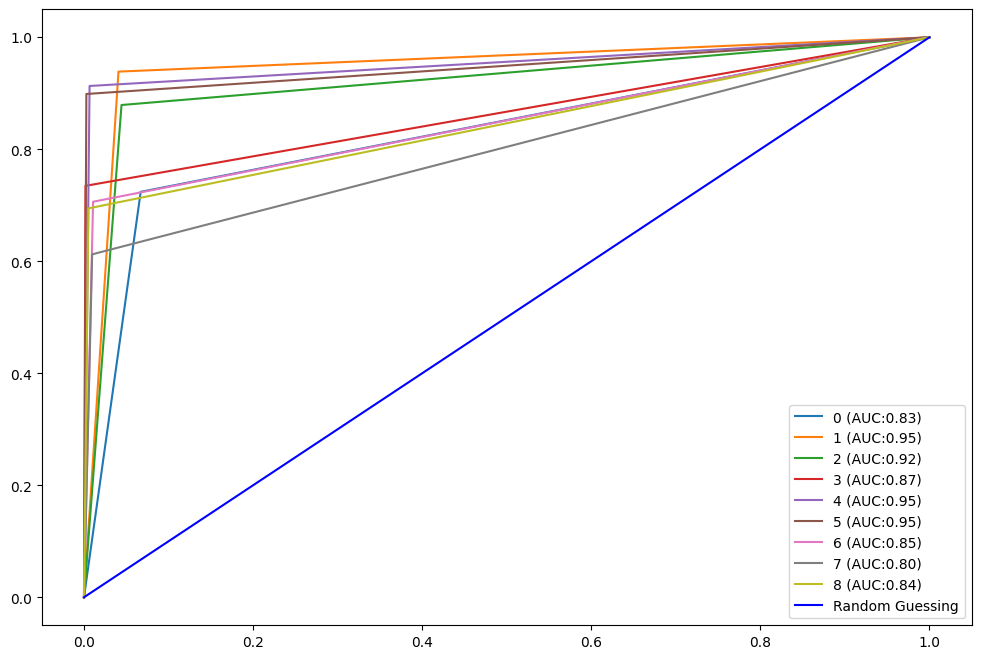

In [36]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score, auc
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    return roc_auc_score(y_test, y_pred, average=average)


test_generator.reset()
y_pred = ensemble_net.predict(test_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
print("Multiclass roc auc score:", multiclass_roc_auc_score(test_generator.classes, y_pred))

# 10. Model exportation

In [36]:
ensemble_net.save("data/workspace/models/ensamble_model.h5")

# 11. Plot model as graph of layers

In [17]:
from keras.utils import plot_model

In [ ]:
plot_model(ensemble_net, show_shapes=True, to_file='model_ensemble.png')